<a href="https://colab.research.google.com/github/SiweiLuo/DL_with_Python/blob/master/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import numpy as np
from keras.utils import to_categorical

data = np.array([1, 5, 3, 9])
print(data)

def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded
  
  
  

[1 5 3 9]


In [109]:
from keras.datasets import mnist

(x_train,y_train),(x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float32')/255.
x_train = x_train.reshape(x_train.shape+(1,))

x_test = x_test.astype('float32')/255.
x_test = x_test.reshape(x_test.shape+(1,))

y_train = encode(y_train)
y_test = encode(y_test)

y_train[0]


Shape of data (BEFORE encode): (60000,)
Shape of data (AFTER  encode): (60000, 10)

Shape of data (BEFORE encode): (10000,)
Shape of data (AFTER  encode): (10000, 10)



array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [0]:
import keras
from keras import layers
from keras.models import Model
from keras import backend as K 
import numpy as np 

img_shape = (28,28,1)
batch_size = 16

input_img = layers.Input(shape=(img_shape))

x = layers.Conv2D(32,3,padding='same',activation='relu')(input_img)
x = layers.Conv2D(64,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(10,activation='softmax')(x)

encoder = Model(input_img,x)

In [111]:
encoder.compile(optimizer='rmsprop',loss='categorical_crossentropy')

encoder.fit(x_train,y_train,batch_size=batch_size,validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 294s 5ms/step - loss: 0.1015 - val_loss: 0.0370


In [0]:
y_score = encoder.predict(x_train[1:2])

In [113]:
y_score[0]

array([9.9999893e-01, 3.9812264e-13, 2.0060396e-07, 1.5098428e-11,
       3.4029747e-12, 1.8285344e-11, 8.7259133e-07, 2.5178570e-10,
       3.6354517e-09, 5.2967697e-09], dtype=float32)

In [0]:
def sampling(args):
  x = args
  return x
  
z = layers.Lambda(sampling)(x)

In [0]:

decoder_shape = (10,)

decoder_input = layers.Input(shape=decoder_shape)

y = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
y = layers.Reshape(shape_before_flattening[1:])(y)
y = layers.Conv2DTranspose(32,3,padding='same',activation='relu',strides=(2,2))(y)
y = layers.Conv2D(1,3,padding='same',activation='sigmoid')(y)

decoder = Model(decoder_input,y)

z_decoded = decoder(x)



In [0]:
class CustomVariationalLayer(keras.layers.Layer):
  def vae_loss(self,y,z_decoded):
    y = K.flatten(y)
    z_decoded = K.flatten(z_decoded) 
    xent_loss = keras.metrics.categorical_crossentropy(y,z_decoded)
    return K.mean(xent_loss)
  
  def call(self,inputs):
    y = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(y,z_decoded)
    self.add_loss(loss,inputs=inputs)
    return y
    
q = CustomVariationalLayer()([input_img,z_decoded])
    

In [117]:
#encoder.trainable = False

vae = Model(input_img,q)

for layer in vae.layers[:7]:
   layer.trainable = False

vae.compile(optimizer='rmsprop',loss=None)
vae.summary()

vae.fit(x_train,None,epochs=1,batch_size=batch_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 

In [118]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [119]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [120]:
figure1 = decoder.predict(y_test[8:9])
#figure1 = figure1.astype('float32')*255.
figure1.shape

(1, 28, 28, 1)

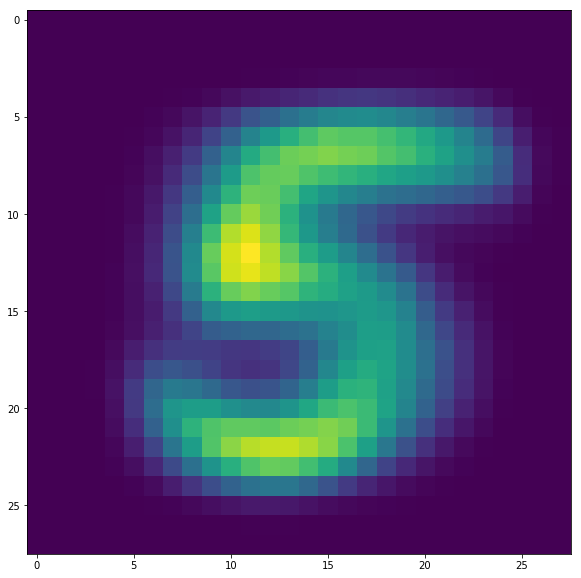

In [121]:
import matplotlib.pyplot as plt
figure1 = figure1.reshape(28,28)
figure1.shape

plt.figure(figsize=(10,10))
plt.imshow(figure1)
plt.show()

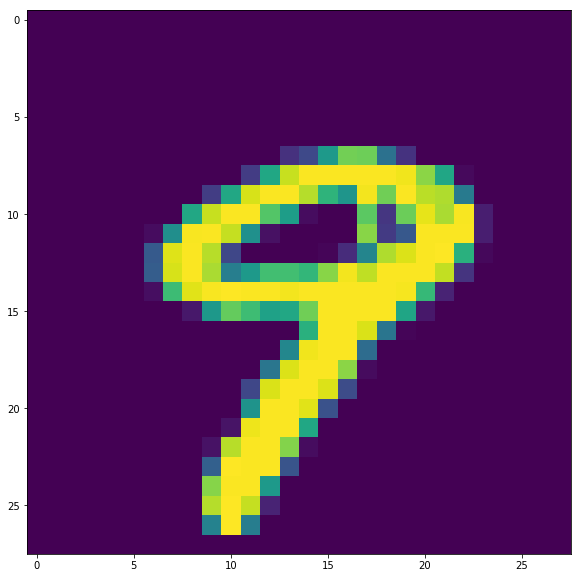

In [124]:
figure2 = x_test[9]
figure2 = figure2.reshape(28,28)
figure2.shape

plt.figure(figsize=(10,10))
plt.imshow(figure2)
plt.show()